In [1]:
import pandas as pd
import polars as pl
import random
import pathlib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
import mlflow
import gc
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import shap

from sklearn.metrics import f1_score
from copy import deepcopy
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score, ConfusionMatrixDisplay, \
    PrecisionRecallDisplay, RocCurveDisplay
from sklearn.compose import make_column_transformer
import logging

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pl.Config(set_fmt_float="full")
pd.options.display.float_format = '{:.3f}'.format
# pd.options.plotting.backend = "matplotlib"

mlflow.set_tracking_uri("../data/mlflow_runs")

In [3]:
## Disable logging warnings
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.disabled = True
    logger.propagate = False

In [4]:
INPUT_DATA_PATH = pathlib.Path("../data/processed.parquet")
SEED = 42
LOG_MODEL = False

In [5]:
from sklearn.calibration import calibration_curve, CalibrationDisplay


def set_seed(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)

def retrieve_categorical_columns_to_encode(dataframe: pd.DataFrame) -> tuple[list[str], list[str]]:
    one_hot_encoded_columns: list[str] = []
    ordinal_encoded_columns: list[str] = []

    for col in dataframe.select_dtypes("category").columns:
        if dataframe[col].nunique() <= 5:
            one_hot_encoded_columns.append(col)
        else:
            ordinal_encoded_columns.append(col)

    return one_hot_encoded_columns, ordinal_encoded_columns

def store_metrics(y_valid: pd.Series, y_pred: pd.Series, y_pred_proba: pd.Series, valid_sample_weight: np.ndarray) -> dict[str, float]:
    fig = ConfusionMatrixDisplay.from_predictions(y_true=y_valid, y_pred=y_pred, normalize="all", sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="confusion_matrix.png")

    fig = PrecisionRecallDisplay.from_predictions(y_true=y_valid, y_pred=y_pred_proba, sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="precision_recall_curve.png")

    fig = RocCurveDisplay.from_predictions(y_true=y_valid, y_pred=y_pred_proba, sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="roc_curve.png")

    fig = CalibrationDisplay.from_predictions(y_true=y_valid, y_prob=y_pred_proba, n_bins=10)
    mlflow.log_figure(fig.figure_, artifact_file="calibration_curve.png")

    conf_matrix: np.ndarray = confusion_matrix(y_pred=y_pred, y_true=y_valid, labels=[0,1], sample_weight=valid_sample_weight)
    tn, fp, fn, tp = conf_matrix.ravel()

    epsilon = 1e-15

    # Calculate metrics
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    balanced_accuracy = (recall + specificity) / 2
    f1 = (2 * precision * recall) / (precision + recall + epsilon)
    false_positive_rate = fp / (fp + tn + epsilon)
    false_negative_rate = fn / (fn + tp + epsilon)
    mcc = (tp * tn - fp * fn) / (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5 + epsilon)
    fowlkes_mallows_index = tp / (((tp + fp) * (tp + fn)) ** 0.5 + epsilon)
    roc_auc = roc_auc_score(y_true=y_valid, y_score=y_pred_proba, sample_weight=valid_sample_weight, average="weighted")
    average_precision = average_precision_score(y_true=y_valid, y_score=y_pred_proba, sample_weight=valid_sample_weight, average="weighted")

    metrics = {
        "accuracy": round(accuracy, 3),
        "balanced_accuracy": round(balanced_accuracy, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "specificity": round(specificity, 3),
        "f1": round(f1, 3),
        "false_positive_rate": round(false_positive_rate, 3),
        "false_negative_rate": round(false_negative_rate, 3),
        "average_precision": round(average_precision, 3),
        "mcc": round(mcc, 3),
        "fowlkes_mallows_index": round(fowlkes_mallows_index, 3),
        "auc": round(roc_auc, 3),
    }
    
    mlflow.log_metrics(metrics)
    
    return metrics

def compute_feature_importances(pipeline, X_train, X_valid) -> pd.DataFrame:
    shap_values = shap.LinearExplainer(pipeline["model"], X_train, nsamples=100_000, seed=SEED).shap_values(X_valid)
    
    feature_importances: pd.DataFrame = pd.DataFrame(data={"column": list(X_valid.columns), "importance": np.mean(shap_values, axis=0)}).sort_values(by="importance", ascending=True)
    mlflow.log_table(feature_importances, "feature_importances.json")

    # fig = px.histogram(feature_importances, x="importance", y="column", orientation="h", width=1500, height=1500)
    # mlflow.log_figure(fig, artifact_file="feature_importances.png")

    return feature_importances


In [6]:
set_seed(SEED)
data: pl.LazyFrame = pl.scan_parquet(INPUT_DATA_PATH).drop("last_activity", "ID", "days_since_last_activity").with_columns(pl.col(pl.Float64).cast(pl.Float32))

X: pd.DataFrame = data.drop("churned").collect().to_pandas()

y: np.ndarray = data.select("churned").collect().to_pandas().churned.values

In [7]:
gc.collect()

4

## Train model

In [8]:
mlflow.sklearn.autolog(
    log_input_examples=False,
    log_model_signatures=True,
    log_models=False,
    log_datasets=False,
    disable=False,
    exclusive=False,
    disable_for_unsupported_versions=False,
    silent=False,
    registered_model_name=None,
    extra_tags=None
)


In [9]:
from sklearn.base import ClassifierMixin


def train_cross_validation(model, X: pd.DataFrame, y: np.ndarray, compute_importances: bool) -> str:
    with mlflow.start_run() as main_run:
        run_id = main_run.info.run_id

        cross_validator: StratifiedKFold = StratifiedKFold(n_splits=5)
        
        metrics = {
            "accuracy": [],
            "balanced_accuracy": [],
            "precision": [],
            "recall": [],
            "specificity": [],
            "f1": [],
            "false_positive_rate": [],
            "false_negative_rate": [],
            "average_precision": [],
            "mcc": [],
            "fowlkes_mallows_index": [],
            "auc": [],
        }
        for i, (train_index, test_index) in enumerate(cross_validator.split(X, y)):
            print(f"Training {i+1} split")
            
            X_train, y_train = X.loc[train_index], y[train_index]
            X_valid, y_valid = X.loc[test_index], y[test_index]
            train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
            valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)
            
            
            with mlflow.start_run(nested=True, run_name=f"Split_{i+1}", log_system_metrics=True):
                mlflow.log_param("columns", list(X_train.columns))
                model.fit(X_train, y_train, model__sample_weight=train_sample_weights)
            
                y_pred_proba = model.predict_proba(X_valid)[:, 1]
                threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=model, sample_weight=valid_sample_weights)
                y_pred = y_pred_proba > threshold
                
                mlflow.log_metric("threshold", threshold)
                
                
                if compute_importances:
                    compute_feature_importances(pipeline=model, X_train=model["column_transformer"].transform(X_train), X_valid=model["column_transformer"].transform(X_valid))
                else:
                    feature_importances: pd.DataFrame = pd.DataFrame(data={"column": model["model"].feature_names_in_, "importance": model["model"].feature_importances_}).sort_values(by="importance", ascending=False)
                    mlflow.log_table(feature_importances, "feat_importances.json")
                
                metrics_split = store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
                for metric_key in metrics_split:
                    metrics[metric_key].append(metrics_split[metric_key])
            
        for metric_name in metrics:
            metric_mean = np.mean(metrics[metric_name])
            metric_std = np.std(metrics[metric_name])
            mlflow.log_metrics({f"{metric_name}_mean": metric_mean, f"{metric_name}_std": metric_std})
    
    return run_id
            
def train_full_model(model, X: pd.DataFrame, y: np.ndarray, compute_importances: bool) -> tuple[ClassifierMixin, pd.DataFrame]:
    print(f"Train full model")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)
    
    
    with mlflow.start_run(nested=True, run_name=f"Full model", log_system_metrics=True):
        mlflow.log_param("columns", list(X.columns))
        model.fit(X_train, y_train, model__sample_weight=train_sample_weights)

        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=model, sample_weight=valid_sample_weights)
        y_pred = y_pred_proba > threshold
        mlflow.log_metric("threshold", threshold)
        
        if compute_importances:
            feature_importances = compute_feature_importances(pipeline=model, X_train=model["column_transformer"].transform(X_train), X_valid=model["column_transformer"].transform(X_valid))
        else:
            feature_importances = None

        store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
        
    return model, feature_importances

def compute_threshold(X: pd.DataFrame, y: np.ndarray, model: CalibratedClassifierCV, sample_weight: np.ndarray) -> tuple[float, float]:
    thresholds: np.ndarray = np.arange(start=0.05, stop=1.05, step=0.05)
    output: np.ndarray = np.vectorize(lambda x: f1_score(y_true=y, y_pred=model.predict_proba(X)[:, 1] > x, sample_weight=sample_weight))(thresholds)
    max_index: int = np.argmax(output)
    
    return float(thresholds[max_index]), float(output[max_index])

# def train_logistic_regression_model(X, y):
#     mlflow.set_experiment("logistic_regression_model")
# 
#     pipeline = Pipeline(
#         steps=[
#             ("column_transformer", column_transformer),
#             ("model", LogisticRegression(verbose=0, random_state=SEED, n_jobs=-1, warm_start=False))
#         ]
#     )
#     
#     # mlflow_run = train_cross_validation(pipeline, X, y, compute_importances=True)
# 
#     columns_to_drop = []
#     while True:
#         model, feature_importances = train_full_model(pipeline, X.drop(columns=columns_to_drop), y, compute_importances=True)
# 
#         new_columns_to_drop = feature_importances.query("importance <= 0").column.tolist()
#         if not new_columns_to_drop:
#             break
# 
#         columns_to_drop.extend(new_columns_to_drop)
# 
#     threshold, max_f1_score = compute_threshold(X.drop(columns=columns_to_drop), y, model)
#     print(f"Max f1 score of {max_f1_score:.3f} obtained with threshold of: {threshold:.3f}")
# 
# def train_random_forest_model(X, y):
#     mlflow.set_experiment("random_forest_model")
#     
#     pipeline = Pipeline(
#         steps=[
#             ("column_transformer", column_transformer),
#             ("model", RandomForestClassifier(verbose=0, random_state=SEED, n_jobs=-1, warm_start=False))
#         ]
#     )
# 
#     mlflow_run = train_cross_validation(pipeline, X, y, compute_importances=False)
# 
#     columns_to_drop = []
#     while True:
#         model, _ = train_full_model(pipeline, X.drop(columns=columns_to_drop), y, compute_importances=False)
# 
#         feature_importances: pd.DataFrame = pd.DataFrame(data={"column": model.feature_names_in_, "importance": model.feature_importances_})
# 
#         new_columns_to_drop = feature_importances.query("importance <= 0").column.tolist()
#         if not new_columns_to_drop:
#             break
# 
#         columns_to_drop.extend(new_columns_to_drop)
# 
#     threshold, max_f1_score = compute_threshold(X.drop(columns=columns_to_drop), y, model)
#     print(f"Max f1 score of {max_f1_score:.3f} obtained with threshold of: {threshold:.3f}")


In [10]:
def train_valid_test_split(X: pd.DataFrame, y: pd.Series | np.ndarray, valid_size: float = 0.1, test_size: float = 0.1, seed: int = 42):
    if test_size + valid_size > 1.:
        raise ValueError(f"validation and test size must be less than 1.0")
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size/X_train.shape[0], random_state=seed, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [11]:
def define_pipeline(data: pd.DataFrame, model) -> Pipeline:
    standardized_columns: list[str] = data.select_dtypes(include="number").columns.tolist()
    one_hot_encoded_columns, ordinal_encoded_columns = retrieve_categorical_columns_to_encode(data)


    column_transformer = make_column_transformer(
        (OneHotEncoder(dtype=np.float32, sparse_output=False, drop="first", handle_unknown="ignore"), one_hot_encoded_columns),
        (OrdinalEncoder(dtype=np.float32, unknown_value=-1, handle_unknown="use_encoded_value"), ordinal_encoded_columns),
        (RobustScaler(), standardized_columns),
        remainder="passthrough",
        n_jobs=-1,
        verbose=1,
        verbose_feature_names_out=False
    ).set_output(transform="pandas")


    return Pipeline(
        steps=[
            ("column_transformer", column_transformer),
            ("model", model)
        ]
    )

def train_model(model: BaseEstimator, X: pd.DataFrame, y: np.ndarray, compute_importances: bool, run_id: str | None = None):        
    pipeline = define_pipeline(X, model)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)


    with mlflow.start_run(run_id=run_id, nested=True, run_name=f"Full model", log_system_metrics=True):
        mlflow.log_param("columns", list(X.columns))
        pipeline.fit(X_train, y_train, model__sample_weight=train_sample_weights)

        y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]
        threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=pipeline, sample_weight=valid_sample_weights)
        y_pred = y_pred_proba > threshold
        mlflow.log_metric("threshold", threshold)

        if LOG_MODEL:
            mlflow.sklearn.log_model(
                calibrated_classifier,
                artifact_path="model.pkl",
                registered_model_name="model",
                pyfunc_predict_fn="predict_proba",
                signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
            )

        if compute_importances:
            feature_importances = compute_feature_importances(pipeline=pipeline, X_train=pipeline["column_transformer"].transform(X_train), X_valid=pipeline["column_transformer"].transform(X_valid))
        else:
            feature_importances: pd.DataFrame = pd.DataFrame(data={"column": pipeline["model"].feature_names_in_, "importance": pipeline["model"].feature_importances_}).sort_values(by="importance", ascending=False)
            feature_importances["importance"] = feature_importances["importance"].astype(np.float32)
            mlflow.log_table(feature_importances, "feat_importances.json")

        store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
        
    return pipeline, feature_importances

def train_calibrated_model(model: BaseEstimator, X: pd.DataFrame, y: np.ndarray, compute_importances: bool, run_id: str | None = None):
    pipeline = define_pipeline(X, model)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)
    # test_sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)


    with mlflow.start_run(run_id=run_id, nested=True, run_name=f"Full model", log_system_metrics=True):
        mlflow.log_params({"columns": list(X.columns), "num_columns": X.shape[1]})
        pipeline.fit(X_train, y_train, model__sample_weight=train_sample_weights)

        fig = CalibrationDisplay.from_predictions(y_true=y_valid, y_prob=pipeline.predict_proba(X_valid)[:, 1], n_bins=10, name="original calibration curve")
        mlflow.log_figure(fig.figure_, artifact_file="original_calibration_curve.png")
        threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=pipeline, sample_weight=valid_sample_weights)
        mlflow.log_metric("threshold_uncalibrated", threshold)

        calibrated_classifier: CalibratedClassifierCV = CalibratedClassifierCV(pipeline, cv="prefit", method="isotonic", n_jobs=-1)
        calibrated_classifier.fit(X_valid, y_valid, sample_weight=valid_sample_weights)

        y_pred_proba = calibrated_classifier.predict_proba(X_valid)[:, 1]
        threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=calibrated_classifier, sample_weight=valid_sample_weights)
        y_pred = y_pred_proba > threshold
        mlflow.log_metric("threshold", threshold)

        if LOG_MODEL:
            mlflow.sklearn.log_model(
                calibrated_classifier,
                artifact_path="model.pkl",
                registered_model_name="model",
                pyfunc_predict_fn="predict_proba",
                signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
            )

        if compute_importances:
            feature_importances = compute_feature_importances(pipeline=pipeline, X_train=pipeline["column_transformer"].transform(X_train), X_valid=pipeline["column_transformer"].transform(X_valid))
        else:
            feature_importances: pd.DataFrame = pd.DataFrame(data={"column": pipeline["model"].feature_names_in_, "importance": pipeline["model"].feature_importances_}).sort_values(by="importance", ascending=False)
            feature_importances["importance"] = feature_importances["importance"].astype(np.float32)
            mlflow.log_table(feature_importances, "feat_importances.json")

        store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)

    return pipeline, feature_importances

def train_iterative_model(model, X: pd.DataFrame, y: np.ndarray, calibration: bool = True):
    cols_to_drop = []

    with mlflow.start_run(nested=False):
        while True:
            X_transformed = X.drop(columns=cols_to_drop)
            
            if calibration:
                rf_model, feature_importances = train_calibrated_model(model=model, X=X_transformed, y=y, compute_importances=False)
            else:
                rf_model, feature_importances = train_model(model=model, X=X_transformed, y=y, compute_importances=False)

            new_cols_to_drop = feature_importances[feature_importances.importance <= 1e-4].column.tolist()
            new_cols_to_drop = list(set(new_cols_to_drop).intersection(list(X.columns)))

            if not new_cols_to_drop:
                print(f"no new columns to drop")
                break

            else:
                cols_to_drop.extend(new_cols_to_drop)

In [12]:
if False:
    mlflow.set_experiment("random_forest_model")
    
    rf_model: RandomForestClassifier = RandomForestClassifier(verbose=0, random_state=SEED, n_jobs=-1, warm_start=False)
    train_iterative_model(model=rf_model, X=X, y=y, calibration=True)

## Train logistic regression model

In [13]:
if False:
    mlflow.set_experiment("logistic_regression_model")
    
    lr_model: LogisticRegression = LogisticRegression(verbose=0, random_state=SEED, n_jobs=-1, warm_start=False)
    
    pipeline = define_pipeline(X, lr_model)
    # run_id = train_cross_validation(model=pipeline, X=X, y=y, compute_importances=True)
    
    train_iterative_model(model=lr_model, X=X, y=y)

## Train Lightgbm

In [ ]:
import lightgbm as lgb
import plotly.graph_objects as go

def get_learning_curves(model: lgb.LGBMModel, metric: str = "binary_logloss") -> go.Figure:
    keys = list(model.evals_result_.keys())
    train_key, valid_key = "", ""
    for key in keys:
        if "train" in key:
            train_key = key
        elif "valid" in key:
            valid_key = key

    results = pd.DataFrame({"train": model.evals_result_[train_key][metric], "valid": model.evals_result_[valid_key][metric]})

    fig = go.Figure()
    for col in results.columns:
        fig.add_trace(go.Scatter(x=results.index+1, y=results[col], mode='lines', name=f"{col}"))

    fig.update_layout(title=f'Learning curves {metric}',
                      xaxis_title='Iteration',
                      yaxis_title=metric,
                      margin=dict(l=0,r=0,b=0,t=30),
                      )
    return fig

mlflow.set_experiment(experiment_name="lightgbm_model")
mlflow.lightgbm.autolog(
    log_input_examples=False,
    log_model_signatures=True,
    log_models=False,
    log_datasets=False,
    disable=False,
    exclusive=False,
    disable_for_unsupported_versions=False,
    silent=False,
    registered_model_name=None,
    extra_tags=None
)

lgb_model = lgb.LGBMClassifier(
    random_state=SEED,
    n_jobs=-1,
    boosting_type='gbdt',
    num_leaves=128,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=1_000,
    subsample_for_bin=200_000,
    objective="binary",
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20, # min_data_in_leaf
    subsample=1.,
    subsample_freq=0,
    colsample_bytree=1.,
    # reg_alpha=10.0,
    # reg_lambda=10.0,
    importance_type='gain',
    device="cpu",
    deterministic=True,
    verbose=-1,
    # extra_trees=True,
    # extra_seed=SEED
)

cols_to_drop = []
X["noise"] = np.random.normal(size=X.shape[0])

with mlflow.start_run(nested=False):
    while True:
        X_transformed = X.drop(columns=cols_to_drop)

        # pipeline = define_pipeline(X, lgb_model)

        X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.2, random_state=SEED, stratify=y)
        train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
        valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)
        # test_sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)
    
    
        with mlflow.start_run(nested=True, run_name=f"Full model", log_system_metrics=True) as run:
            eval_results = {}
            mlflow.log_params({"columns": list(X_transformed.columns), "num_columns": X_transformed.shape[1]})

            lgb_model = lgb_model.fit(
                X=X_train, 
                y=y_train, 
                sample_weight=train_sample_weights,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric=["binary_logloss", "average_precision", "auc"],
                eval_sample_weight=[train_sample_weights, valid_sample_weights],
                # eval_init_score=[train_init_score, valid_init_score],
                callbacks=[
                    # lgb.log_evaluation(),
                    lgb.record_evaluation(eval_results),
                    lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
                ],
            )

            # fig = CalibrationDisplay.from_predictions(y_true=y_valid, y_prob=lgb_model.predict_proba(X_valid)[:, 1], n_bins=10, name="original calibration curve")
            # mlflow.log_figure(fig.figure_, artifact_file="original_calibration_curve.png")
            # threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=lgb_model, sample_weight=valid_sample_weights)
            # mlflow.log_metric("threshold_uncalibrated", threshold)
    
            calibrated_classifier: CalibratedClassifierCV = CalibratedClassifierCV(lgb_model, cv="prefit", method="isotonic", n_jobs=-1)
            calibrated_classifier.fit(X_valid, y_valid, sample_weight=valid_sample_weights)
            
            y_pred_proba = calibrated_classifier.predict_proba(X_valid)[:, 1]
            threshold, _ = compute_threshold(X=X_valid, y=y_valid, model=calibrated_classifier, sample_weight=valid_sample_weights)
            y_pred = y_pred_proba > threshold
            mlflow.log_metric("threshold", threshold)

            if LOG_MODEL:
                mlflow.sklearn.log_model(
                    calibrated_classifier,
                    artifact_path="model.pkl",
                    registered_model_name="model",
                    pyfunc_predict_fn="predict_proba",
                    signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
                )
            
            store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)

            feature_importances: pd.DataFrame = pd.DataFrame(data={"column": lgb_model.feature_name_, "importance": lgb_model.feature_importances_}).sort_values(by="importance", ascending=False)
            
            try:
                noise_importance: float = feature_importances.query("column == 'noise'").importance.item()

                new_cols_to_drop = feature_importances[
                    (feature_importances.column != "noise") & ((feature_importances.importance <= 1e-4) | (feature_importances.importance <= noise_importance))
                    ].column.tolist()
                
                new_cols_to_drop = list(set(new_cols_to_drop).intersection(list(X.columns)))
            except ValueError as e:
                new_cols_to_drop = []
    
            if "noise" in cols_to_drop:
                print(f"Stopping")
                break
            elif not new_cols_to_drop:
                print(f"no new columns to drop. Final training step without the noise column")
                cols_to_drop.append("noise")
                LOG_MODEL = True
            else:
                cols_to_drop.extend(new_cols_to_drop)

In [23]:
lgbm_shap = lgb_model.predict_proba(X_valid, pred_contrib=True)[:, :-1]

In [29]:
lgb_model.predict_proba(X_valid, pred_contrib=False)

array([[0.27530839, 0.72469161],
       [0.35183414, 0.64816586],
       [0.62310535, 0.37689465],
       ...,
       [0.27441366, 0.72558634],
       [0.93809637, 0.06190363],
       [0.29841137, 0.70158863]])

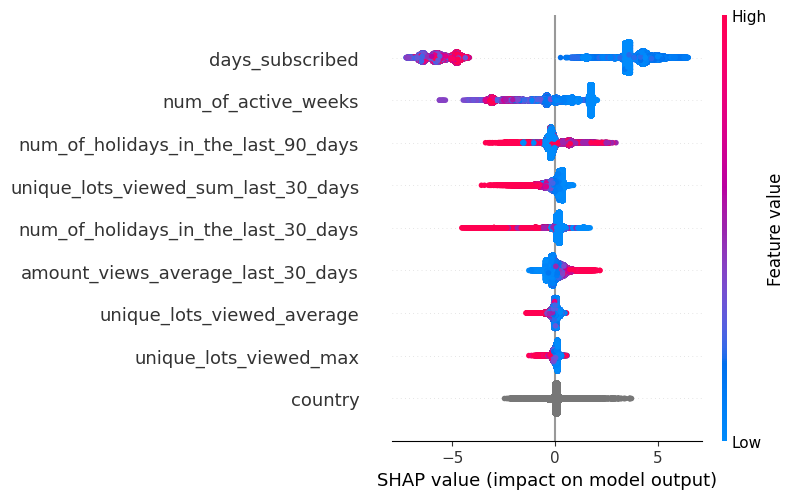

In [33]:
import shap

shap.summary_plot(lgbm_shap, X_valid)

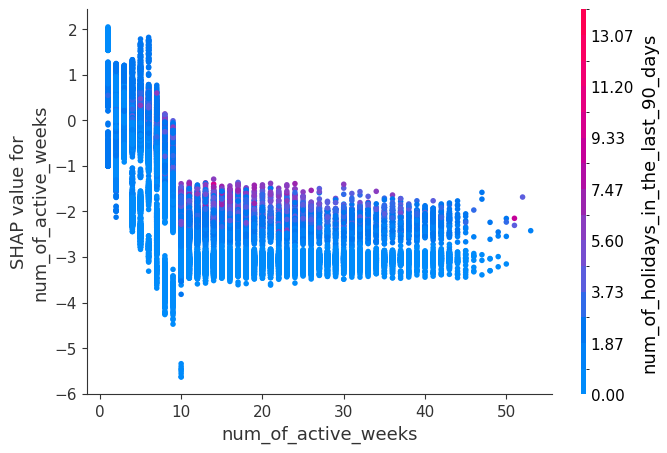

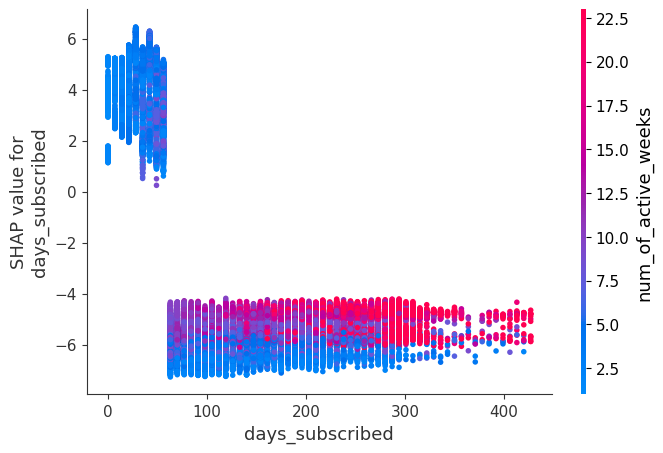

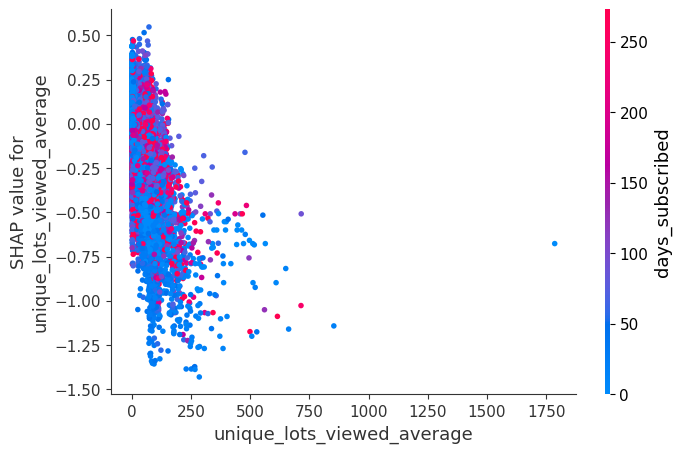

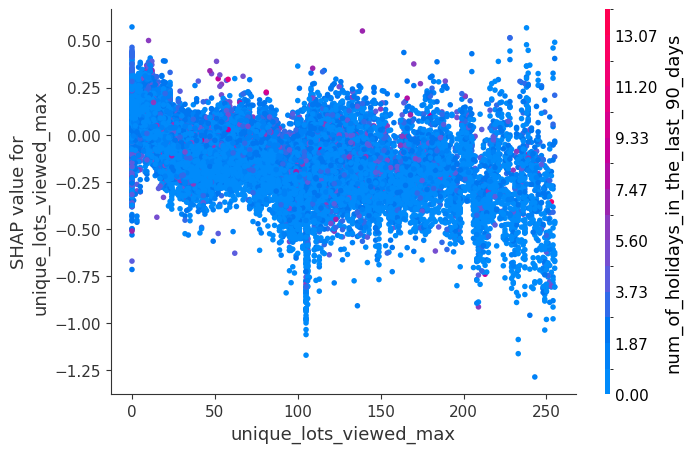

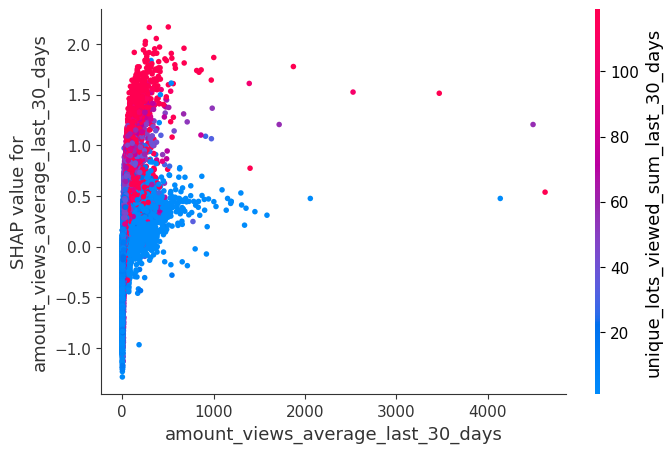

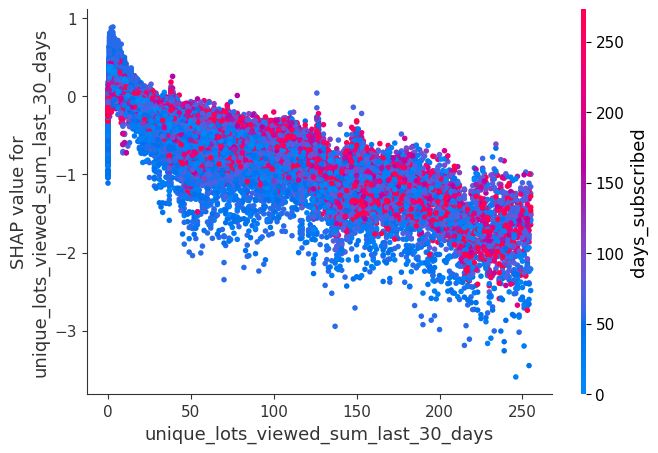

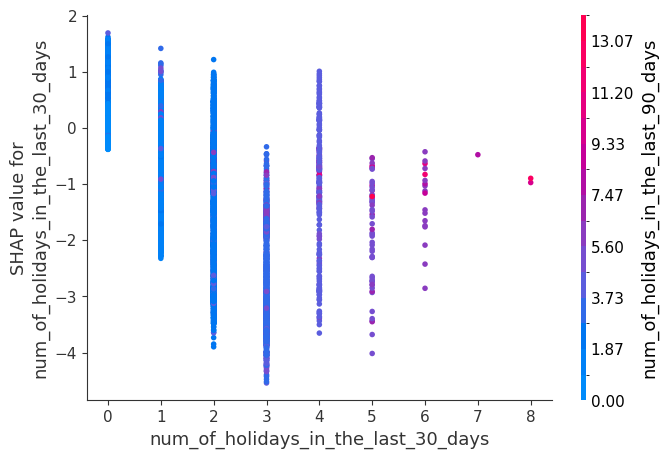

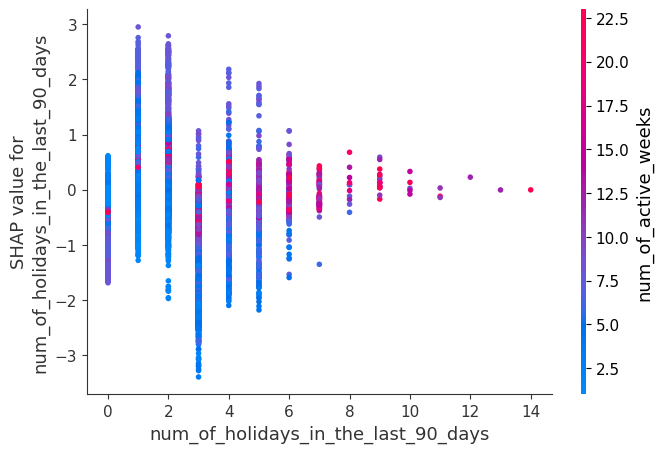

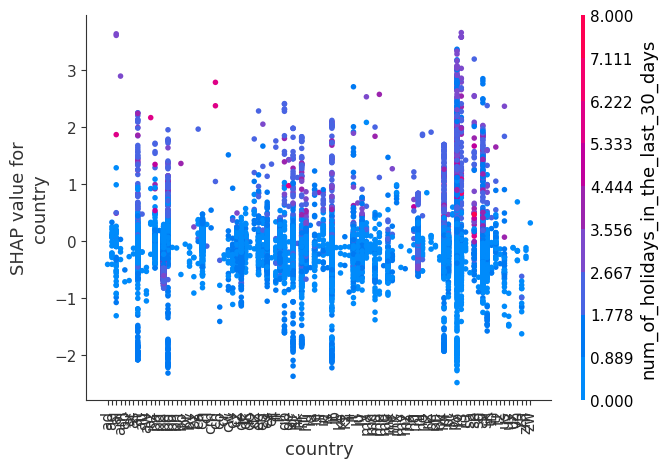

In [35]:
for name in X_valid.columns:
    shap.dependence_plot(name, lgbm_shap, X_valid)